In [5]:
import matplotlib.pyplot as plt
import numpy as np

import astropy
import astropy.coordinates
from astropy.time import Time

329.5869997292757

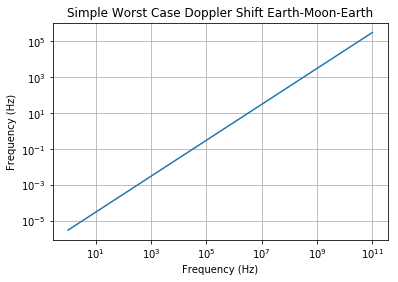

In [196]:
c = 299792458 #m/s
doppler = lambda f, v: f/((1-v**2/c**2)**(1/2)*(1 + v/c))


plt.xscale('log')
plt.yscale('log')
freq = np.geomspace(1, 10e10)
moon_recieve = doppler(freq, 460)
earth_recieve = doppler(moon_recieve, 460)
shift = freq- earth_recieve 

plt.grid()
plt.title('Simple Worst Case Doppler Shift Earth-Moon-Earth')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency (Hz)')
plt.plot(freq, shift)


f = doppler(107.4e6, 460)
f2 = doppler(f, 460)
107.4e6-f2



In [180]:
from astropy.utils import iers
from astropy.coordinates import get_body_barycentric,get_body_barycentric_posvel, get_body, get_moon
from astropy.coordinates import solar_system_ephemeris
from astropy.coordinates import EarthLocation
from astropy import units
from astropy.coordinates import CartesianRepresentation, CartesianDifferential, SkyCoord, GCRS
from math import acos, cos

iers.conf.iers_auto_url = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'
solar_system_ephemeris.set('jpl') 


c = 299792458 #m/s
doppler = lambda f, v, costheta: f/((1-v**2/c**2)**(1/2) *  (1 + v/c * costheta))


def get_doppler(frequency, emitter, reciever, time):
    #ICRS
    moon_loc, moon_vel = get_body_barycentric_posvel('moon', time)
    moon_loc = SkyCoord(
        representation_type = 'cartesian', differential_type=CartesianDifferential,unit='m',frame='icrs', 
        obstime =time, x = moon_loc.x, y= moon_loc.y, z = moon_loc.z, v_x = moon_vel.x, v_y = moon_vel.y, v_z = moon_vel.z)
    moon_coord = moon_loc.transform_to(GCRS(obstime=time))

    #GCRS
    emitter_loc, emitter_vel = emitter.get_gcrs_posvel(time)
    emitter_coord = SkyCoord(
        representation_type = 'cartesian', differential_type=CartesianDifferential,unit='m',frame='gcrs', 
        obstime =time, x = emitter_loc.x, y= emitter_loc.y, z = emitter_loc.z, 
        v_x = emitter_vel.x, v_y = emitter_vel.y, v_z = emitter_vel.z)

    #GCRS
    reciever_loc, reciever_vel = reciever.get_gcrs_posvel(time)
    reciever_coord = SkyCoord(
        representation_type = 'cartesian', differential_type=CartesianDifferential,unit='m',frame='gcrs', 
        obstime =time, x = reciever_loc.x, y= reciever_loc.y, z = reciever_loc.z, 
        v_x = reciever_vel.x, v_y = reciever_vel.y, v_z = reciever_vel.z)


    #Let the moon be reciever, earth source
    #Sign error on angle (?)
    delta_pos_e_m = CartesianRepresentation(x=(emitter_coord.cartesian.xyz-moon_coord.cartesian.xyz), unit='m')
    delta_v_e_m = CartesianDifferential(d_x = (emitter_coord.velocity-moon_coord.velocity).get_d_xyz(), unit='m/s')
    theta_e_m = delta_pos_e_m.dot(delta_v_e_m)/(delta_pos_e_m.norm() * delta_v_e_m.norm())
    delta_v_e_m_norm= delta_v_e_m.norm().value
    shifted_e_m = doppler(frequency, delta_v_e_m_norm, theta_e_m)


    delta_pos_m_e = CartesianRepresentation(x=(moon_coord.cartesian.xyz-reciever_coord.cartesian.xyz), unit='m')
    delta_v_m_e = CartesianDifferential(d_x = (moon_coord.velocity-reciever_coord.velocity).get_d_xyz(), unit='m/s')
    theta_m_e = delta_pos_m_e.dot(delta_v_m_e)/(delta_pos_m_e.norm() * delta_v_m_e.norm())
    delta_v_m_e_norm= delta_v_e_m.norm().value
    shifted_m_e = doppler(shifted_e_m, delta_v_m_e_norm, theta_m_e)

    return (shifted_e_m, shifted_m_e)





In [183]:
from astropy.timeseries import TimeSeries

n = 60*24

start_time = Time('2019-01-01T00:00:00.00Z', format='isot', scale='utc')
times = TimeSeries(time_start=start_time, time_delta =units.Quantity('1h'), n_samples=n)

emitter = EarthLocation.from_geodetic("30°03'10.8","31°13'50.1", 0) #ERTU  Broadcasting
reciever = EarthLocation.from_geodetic("38°25'53.6", "79°49'08.9", 0) #GBT
frequency = 107.4e6

y = np.empty(shape=(2,len(times)))
for i, time in enumerate(times['time']):
    if i%24 == 0:
        print(i/24)
    y1, y2 = get_doppler(frequency, emitter, reciever, time)
    y[0,i] =y1
    y[1,i] = y2
    

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0


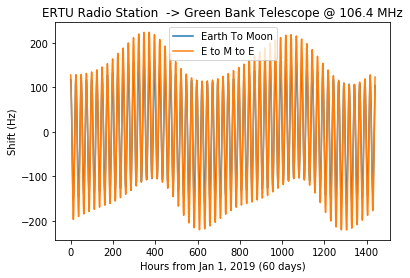

In [209]:
x = range(0, n)
plt.plot(x, y[0]-frequency, label='Earth To Moon')
plt.plot(x, y[1]-frequency, label='E to M to E')
#plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y[1]-frequency, 1))(np.unique(x)))
plt.title('ERTU Radio Station  -> Green Bank Telescope @ 106.4 MHz')
plt.xlabel('Hours from Jan 1, 2019 (%i days)'%(n/24))
plt.ylabel('Shift (Hz)')
plt.legend()

In [ ]:
#Run time improvements
#Day / night cycles
#Compare to data / confirm math is correct

#Intensity estimates (?)
#Corrections for moon radius
#Gravitational(?) correction


#How reflection actually works off of moon
#Error bounding on all steps (i.e. locations on earth, frequency width)
